In [1]:
using QuadGK, Plots, Dates, Base

In [2]:
struct seqCF
    coeff::Vector{Complex{Float64}}  # Les valeurs des coefficients de Fourier
    ind::Vector{Int64}         # Les indices des coefficients
    err::Float64                # L'erreur associée aux coefficients non considérés
    leng::Int64
end

## Product

In [3]:
function prodCF(s1::seqCF, s2::seqCF)
    # Longueur du produit
    leng = s1.leng * s2.leng
    # Initialisation des tableaux avec la taille appropriée
    coeff = Vector{Complex{Float64}}(undef,leng)
    ind = Vector{Int64}(undef, leng)
    idx = 1  # Compteur pour l'indexation dans les vecteurs
    for i in 1:s1.leng
        for j in 1:s2.leng
            ind[idx] = s1.ind[i] + s2.ind[j]  # Somme des indices
            coeff[idx] = s1.coeff[i] * s2.coeff[j]  # Produit des coefficients
            idx += 1  # Incrémenter l'indice
        end
    end
    # Calcul de l'erreur totale
    err = s1.err * s2.err + s1.err * sum(abs.(real(s2.coeff))) + s2.err * sum(abs.(real(s1.coeff)))
    # Retourner un nouvel objet seqCF
    return seqCF(coeff, ind, err, leng)
end

prodCF (generic function with 1 method)

In [4]:
function sortCF(s)
    # Obtenir les indices de tri de l1
    indices_triees = sortperm(s.ind)  # Donne les indices qui trient l1
    # Appliquer le tri à l1 et l2 en utilisant les indices obtenus
    ind = s.ind[indices_triees]
    coeff = s.coeff[indices_triees]
    return seqCF(coeff,ind,s.err,s.leng)
end

sortCF (generic function with 1 method)

In [5]:
function group(s)
    if s.leng==0
        return s
    end
    ind=[s.ind[1]]
    coeff=[s.coeff[1]]
    leng=1
    for i in 2:s.leng
        if s.ind[i]==ind[end]
            coeff[end]+=s.coeff[i]
        else
            leng+=1
            push!(coeff,s.coeff[i])
            push!(ind,s.ind[i])
        end
    end
    return seqCF(coeff,ind,s.err,leng)
end

group (generic function with 1 method)

In [32]:
function threshold(s,t)
    leng=s.leng
    keep=[]
    err=s.err
    for j in 1:leng
        if abs(real(s.coeff[j]))<t
            leng-=1
            err+=abs(real(s.coeff[j]))
        else
            push!(keep,j)
        end
    end
    return seqCF(s.coeff[keep],s.ind[keep],err,leng) 
end

threshold (generic function with 1 method)

In [7]:
function prodCFandReduce(s1,s2,t)
    return threshold(group(sortCF(prodCF(s1::seqCF, s2::seqCF))),t)
end

prodCFandReduce (generic function with 1 method)

## Sum

In [8]:
function sumCF(s1,s2)
    s=seqCF(vcat(s1.coeff,s2.coeff),vcat(s1.ind,s2.ind),s1.err+s2.err,s1.leng+s2.leng)
    return group(sortCF(s))
end

sumCF (generic function with 1 method)

## Main

In [9]:
# Fonction mu
function mu(x, k, l)
    exp_term = exp(l + cos(2 * pi * x))  # Calcul de l'expression récurrente
    return (exp_term^k / factorial(k)) * exp(-exp_term)
end

mu (generic function with 1 method)

In [10]:
# Fonction pour calculer les coefficients complexes de Fourier
function fourier_complex_coefficients(f, N)
    c_n = Complex{Float64}[]  # Initialiser un tableau pour les coefficients complexes
    # Calculer les coefficients pour n allant de -N à N
    for n in -N:N
        # Intégrale pour c_n = ∫ f(x) * exp(-i * n * 2π * x) dx sur [0, 1]
        integral, error = quadgk(x -> f(x) * exp(-im * n * 2π * x), 0, 1)
        push!(c_n, integral)
    end
    return seqCF(c_n,[i for i in -N:N],0,2N+1)
end

fourier_complex_coefficients (generic function with 1 method)

In [11]:
function Coeff_loi_repro(mu,Nmu,M)
    Coeff_mu=[]
    for k in 0:M
        push!(Coeff_mu,fourier_complex_coefficients(x -> mu(x, k), Nmu))
    end
    return Coeff_mu
end

Coeff_loi_repro (generic function with 1 method)

In [12]:
function Doublement(s)
    ind=2 .*s.ind
    return seqCF(s.coeff,ind,s.err,s.leng)
end

Doublement (generic function with 1 method)

In [13]:
function Phi(s,Coeff_mu,M,t)
    produit=seqCF([1],[0],0,1)
    s1=seqCF([],[],0,0)
    for k in 0:M
    s1=sumCF(s1,prodCFandReduce(produit,Coeff_mu[k+1],t))
        if k<M
            produit=prodCFandReduce(produit,s,t)
        end
    end
    return s1
end

Phi (generic function with 1 method)

In [14]:
function fourier_complex_series(s, x_values)
    lenx=length(x_values)
    f_approx = zeros(Complex{Float64}, length(x_values))  # Initialiser le tableau pour f(x)
    # Reconstituer f(x) à partir de la série de Fourier complexe
    for k in 1:lenx
        sum = 0.0 + 0.0im  # Somme initialisée à 0 complexe
        for j in 1:s.leng
            sum += s.coeff[j] * exp(im * s.ind[j] * 2π * x_values[k])  # Utiliser c_n pour reconstruire f(x)
        end
        f_approx[k] = sum
    end
    return real(f_approx)  # Prendre uniquement la partie réelle
end

fourier_complex_series (generic function with 1 method)

In [51]:
# Paramètres
M = 10
Nphi=10 # nombre de fois où on applique la transformation
Nmu=10 # coeff de Fourier des lois de reproductions
x_values = LinRange(0, 1, 1000)  # Points pour tracer la fonction
t=0.000001
l = 0.8

0.8

19,2.4579743927721776e-8,33,3.3651317229950425e-5,61,0.00012012919294908363,93,0.00028701271174345823,159,0.0006846331597491738,259,0.001568242441528284,469,0.003635430848842074,801,0.008513922235641314,1239,0.01994576671024169,1477,0.04666432758280975,

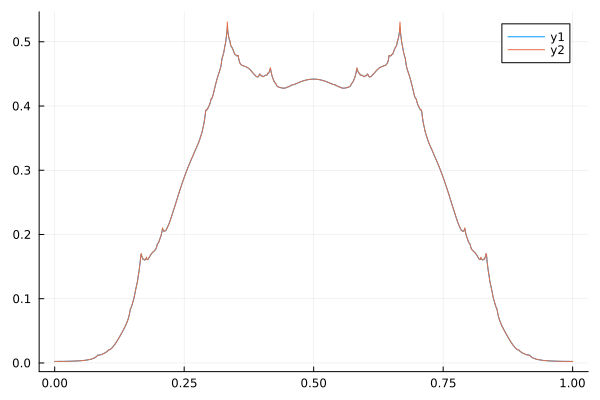

In [52]:
a=0
Coeff_approx=seqCF([a],[0],0,1)
Coeff_mu=Coeff_loi_repro((x,k)->mu(x, k, l),Nmu,M)
for i in 1:Nphi
    Coeff_approx=Doublement(Coeff_approx)
    Coeff_approx=Phi(Coeff_approx,Coeff_mu,M,t) 
    print(Coeff_approx.leng,",",Coeff_approx.err,",")
end 
f_approx = fourier_complex_series(Coeff_approx, x_values)
p=plot(x_values, f_approx)
plot!(x_values,[phi_n(x,0,100,l) for x in x_values])
times=Dates.format(now(),"yyyy-mm-dd_HH-MM-SS")
savefig(homedir() * "/Bureau/plot_Fourier/" * "graphe_$times.png")
display(p)

In [16]:
function phi(x, s, l)
    return exp((s - 1) * exp(l + cos(2 * x * π)))
end

phi (generic function with 1 method)

In [17]:
function phi_n(x, s, n, l)
    if n == 0
        return s
    else
        return phi(x, phi_n(2*x, s, n-1, l),l)
    end
end

phi_n (generic function with 1 method)